In [2]:
# general imports

import os
import sys
import itertools
sys.path.append(os.path.expanduser('~/PythonModules/Own'))

import seaborn as sns
import numpy as np
#import networkx as nx
import scipy.signal as sig
import scipy.constants as csts
import scipy.odr as odr
import matplotlib.pyplot as plt
#import master_equation_simulation_py3 as meq # no python3 support :-((((

from mpl_toolkits.axes_grid1 import make_axes_locatable

# importing own packages and methods

import fitting_functions as func

from plotting import *

# notebook setup

set_sns_standard(context='talk', font='sans-serif', font_scale=1.9)

# do some magix
%matplotlib inline
%load_ext autoreload
%autoreload 2

# define constants
k_B = csts.Boltzmann
mol = csts.Avogadro

/usr/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# import list with residue names
residue_names = []
with open('../working_files/residues_WW.txt') as f:
    for line in f:
        index, name = line.split()
        residue_names.append(index+' '+name)
        
print(residue_names)

['1 LYS', '2 LEU', '3 PRO', '4 PRO', '5 GLY', '6 TRP', '7 GLU', '8 AHA', '9 ARG', '10 MET', '11 SER', '12 ARG', '13 SER', '14 SER', '15 GLY', '16 ARG', '17 VAL', '18 TYR', '19 AZU', '20 PHE', '21 ASN', '22 HIS', '23 ILE', '24 THR', '25 ASN', '26 ALA', '27 SER', '28 GLN', '29 TRP', '30 GLU', '31 ARG', '32 PRO', '33 SER', '34 GLY']


/usr/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


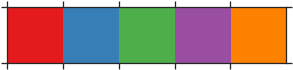

In [4]:
cpalette = sns.color_palette()

cpalette = cpalette[:-1] # delete yellow
l_colormap = len(cpalette)

sns.palplot(cpalette)

def plot_E_kin(E_kin_array, time, plotlabels, saveroot='E_kin_MD', E_kin_model=None, t_model=None, log=True, norm_to_zero=True):
    fig = plt.figure(figsize=(10,6))
    axe = fig.add_subplot(111)
    
    for i, e_kin in enumerate(E_kin_array):
        plabel = plotlabels[i]
        if norm_to_zero:
            lineplot = axe.plot(time, e_kin-e_kin[0], label=plabel, color = cpalette[residue_names.index(plabel)%l_colormap])
        else:
            lineplot = axe.plot(time, e_kin, label=plabel, color = cpalette[residue_names.index(plabel)%l_colormap])

        if type(E_kin_model) != type(None):
            if norm_to_zero:
                axe.plot(t_model, E_kin_model[i]-E_kin_model[i,0], '--', color = lineplot[0].get_color())
            else:
                axe.plot(t_model, E_kin_model[i], '--', color = lineplot[0].get_color())
    
    if log:
        axe.set_xscale('log')
    axe.legend(loc=0)
    axe.set_xlabel('t / ps')
    axe.set_ylabel('E$_{kin}$ / kJ mol$^{-1}$')
    
    if type(E_kin_model) == type(None): 
        axe.set_xlim(xmin=min(time), xmax=max(time))
    elif type(E_kin_model) == type(np.zeros(0)):
        axe.set_xlim(xmin=min(t_model), xmax=max(t_model))
    if norm_to_zero:
        axe.set_ylim(ymin=0)
    if saveroot == 'E_kin_MD_dof':
        axe = fig.gca()
        axe.set_ylabel(axe.get_ylabel()+'dof$^{-1}$')
    
    savename = '/home/thiele/Documents/Physik/HiWi/WW/Plots/' + saveroot
    for resname in plotlabels:
        savename += '_{0}'.format(resname.replace(' ', ''))
    if not log:
        savename += '_lin'
    savename += '.pdf'
    
    fig.tight_layout()
    fig.savefig(savename)
    
    return fig

# MD Data

## Raw results

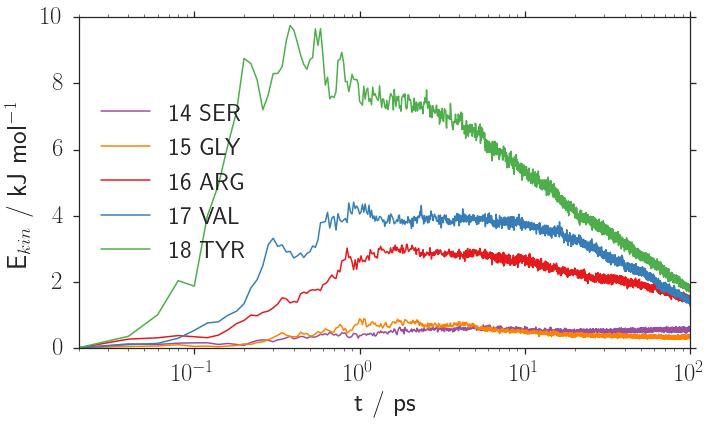

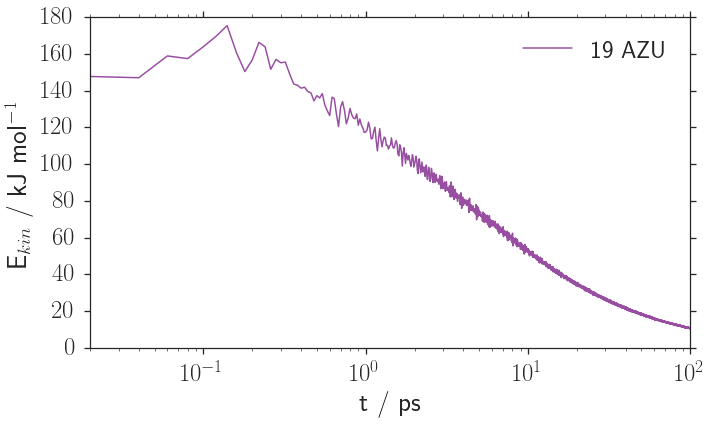

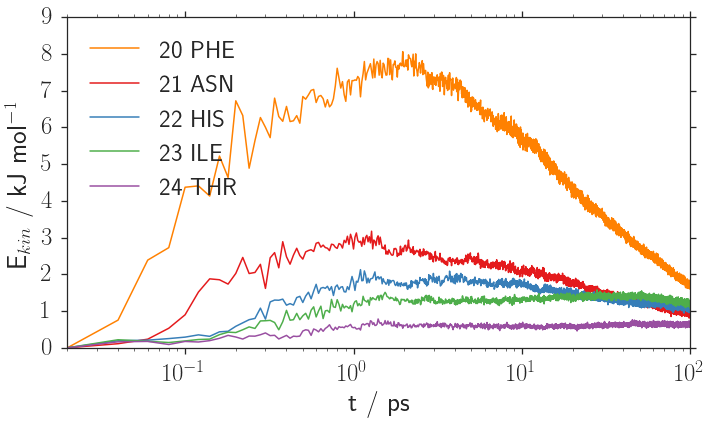

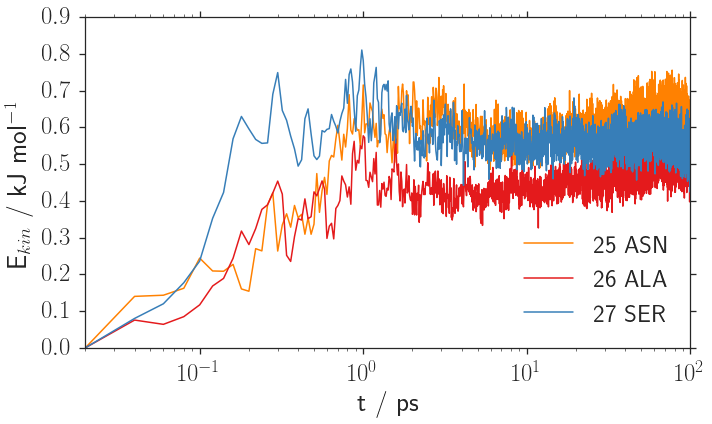

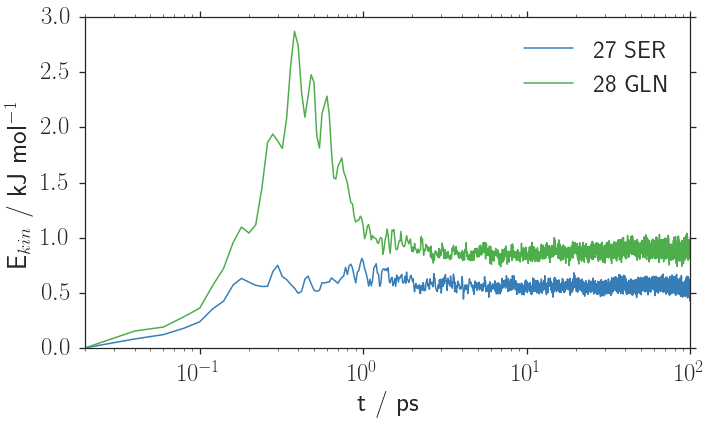

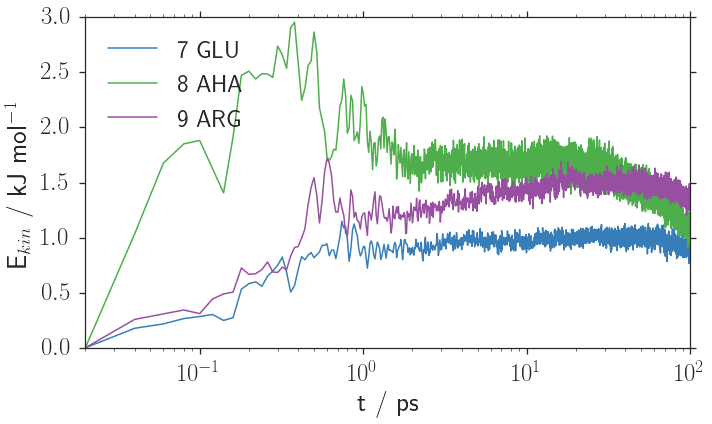

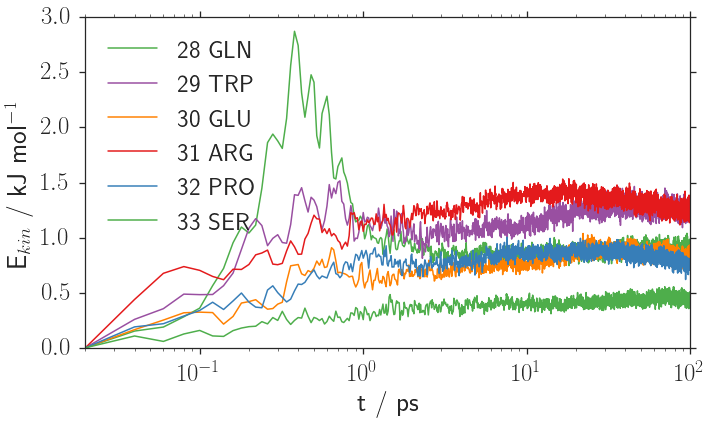

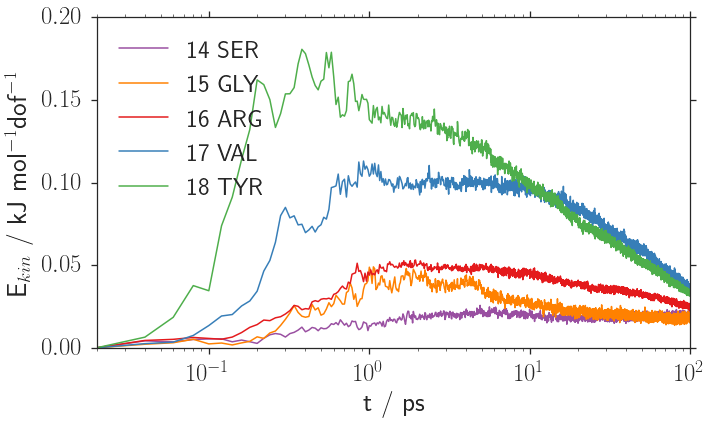

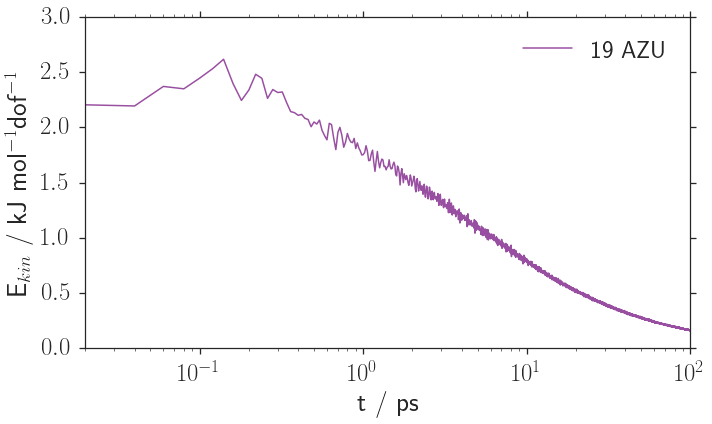

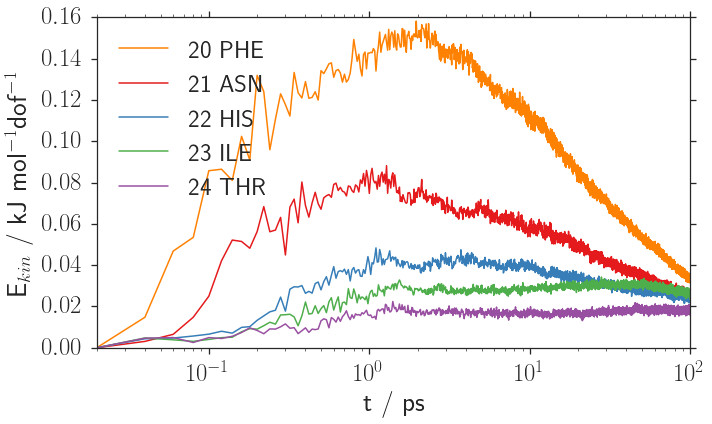

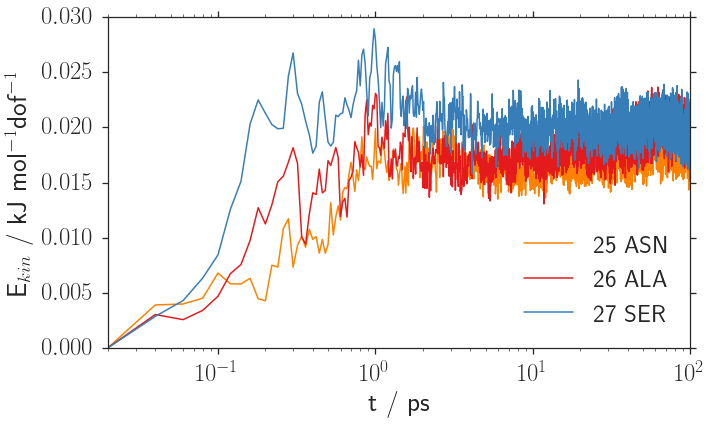

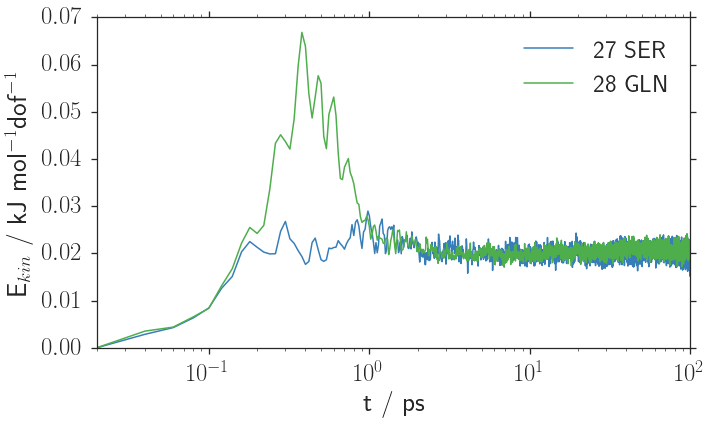

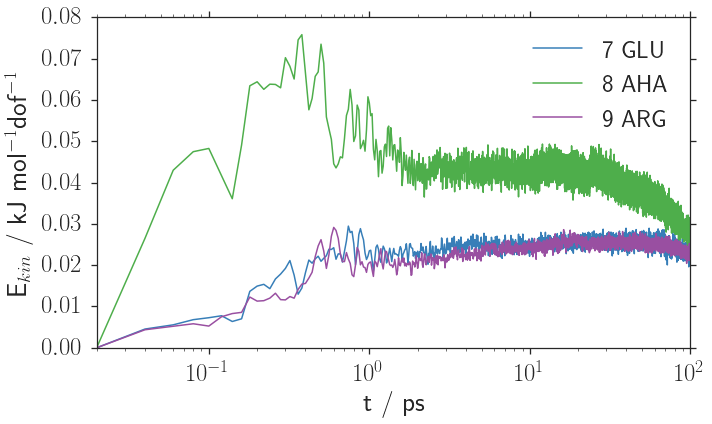

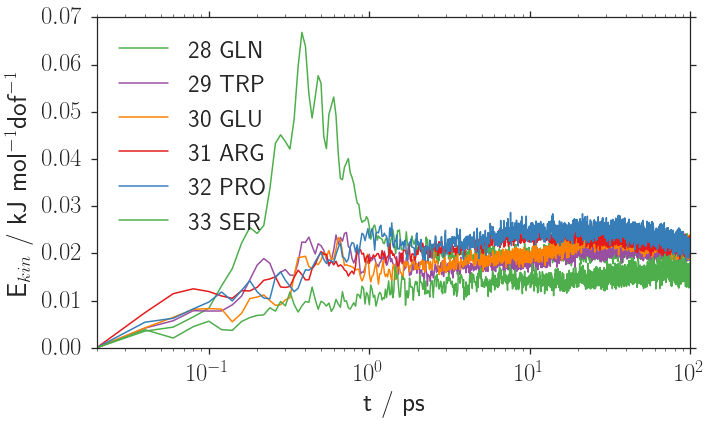

In [69]:
E_kin_MD = np.load('../working_files/910K/E_kin_all_residues_average.npy')/100 # divide by 100 due to MDanalysis units
dof = np.loadtxt('../working_files/BacktrackingData/degrees_of_freedom.txt')

if len(dof) == len(E_kin_MD):
    E_kin_MD_dof = np.zeros_like(E_kin_MD)
    for i in range(len(E_kin_MD)):
        E_kin_MD_dof[i] = E_kin_MD[i]/dof[i]
    
t = np.load('../working_files/time_scale.npy')
time_MD = t

# apply savitzki golay filter to data
'''exponential_intervals = [0]
exponential_intervals += [10**i for i in range(1, int(round(np.log10(len(E_kin_MD[0])))))]

for ekin in E_kin_MD:
    for i in range(len(exponential_intervals)-1):
        if i < len(exponential_intervals)-2:
            index1 = exponential_intervals[i]
            index2 = exponential_intervals[i+1]
            ekin_unfiltered = ekin[index1:index2]
            ekin_filtered = sig.savgol_filter(ekin_unfiltered, 5**(i+1), 4)
            ekin[index1:index2] = ekin_filtered
            
        elif i == len(exponential_intervals)-2:
            index1 = exponential_intervals[i]
            ekin_unfiltered = ekin[index1:]
            ekin_filtered = sig.savgol_filter(ekin_unfiltered, 5**(i+1), 4)
            ekin[index1:] = ekin_filtered'''


plotlabels = residue_names
save_pre = ['E_kin_MD', 'E_kin_MD_dof']

for n, Ekin in enumerate([E_kin_MD, E_kin_MD_dof]):
    for i,j in [(13,18), (18,19), (19,24), (24,27), (26,28), (6,9), (27,-1)]:
        if i != 18:
            fig = plot_E_kin(Ekin[i:j], t, plotlabels[i:j], saveroot=save_pre[n])
        else:
            fig = plot_E_kin(Ekin[i:j], t, plotlabels[i:j], norm_to_zero=False, saveroot=save_pre[n])

#plot_E_kin(E_kin_MD[17:18, :1000], t[:1000], plotlabels[17:18], log=False)
#plot_E_kin(E_kin_MD[15:17], t, plotlabels[15:17], log=False)


# total energy of peptide
#plot_E_kin([np.sum(E_kin_MD, axis=0)[:1000]], time_MD[:1000], plotlabels=['Total energy'], saveroot='E_kin_tot_MD')

## Exponential fit of the decay rate of the heater

5001 5001 0.219999995083 40.0199991055
Beta: [ 112.98741796  -10.31209822   20.94785536   -2.26781071]
Beta Std Error: [  6.77035280e+05   5.62114857e-02   7.16247572e-02   6.17914263e+04]
Beta Covariance: [[  6.90489422e+11   5.14728859e+03  -2.28953749e+03  -6.30193543e+10]
 [  5.14728859e+03   4.75975455e-03   5.14602982e-03  -4.69777024e+02]
 [ -2.28953749e+03   5.14602982e-03   7.72788685e-03   2.08963825e+02]
 [ -6.30193543e+10  -4.69777024e+02   2.08963825e+02   5.75162905e+09]]
Residual Variance: 0.6638432916367862
Inverse Condition #: 4.171801447817732e-10
Reason(s) for Halting:
  Sum of squares convergence
[ 112.98741796  -10.31209822   20.94785536   -2.26781071]
[  1.99999996e-02   3.99999991e-02   5.99999987e-02 ...,   9.99799978e+01
   9.99999978e+01   1.00019998e+02] (array([  10,   11,   12, ..., 4998, 4999, 5000]),)


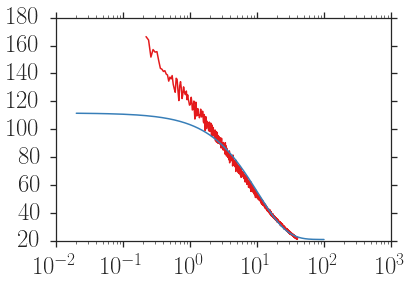

In [9]:
# fit the decay rate of azu to the data
def exp_func(B, x):
    return func.ExponentialC(x, *B)

def f(B, x):
    '''Linear function y = m*x + b'''
    return B[0]*x + B[1]

t = time_MD

#exponential fit
exp_model = odr.Model(exp_func)
print(len(t), len(E_kin_MD[17:18][0]), t[10], t[2000])
azu_data = odr.Data(t[10:2000], E_kin_MD[17:18, 10:2000][0])
azu_odr = odr.ODR(azu_data, exp_model, beta0=[160, -10, 0.21, 0])

azu_fit_results = azu_odr.run()

azu_fit_results.pprint()
popt = azu_fit_results.beta
print(popt)

fig =  plt.figure()
axe = fig.add_subplot(111)

axe.plot(t[10:2000], E_kin_MD[17:18, 10:2000][0])
axe.plot(t, exp_func(popt,t))
axe.set_xscale('log')

#linear fit of logged data
lin_model = odr.Model(f)
#azu_data_ln = 

print(t,np.where(t>0.2))

axe = fig_azu_decay.gca()
axe.plot(t, exp_func(popt,t))
fig_azu_decay.savefig('test.pdf')

# Comparison of MD and MEQ

3.51701677427


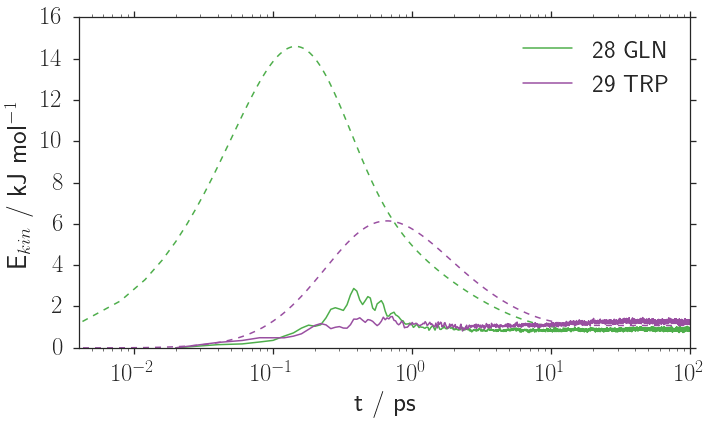

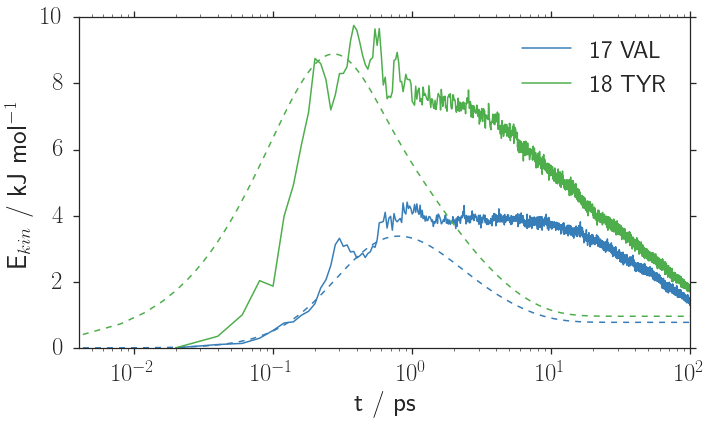

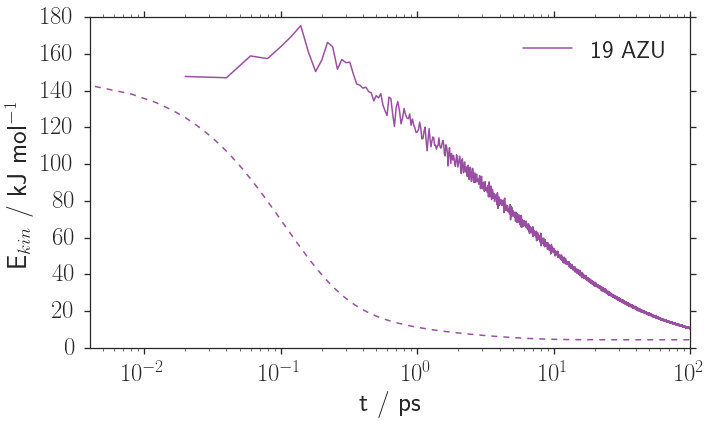

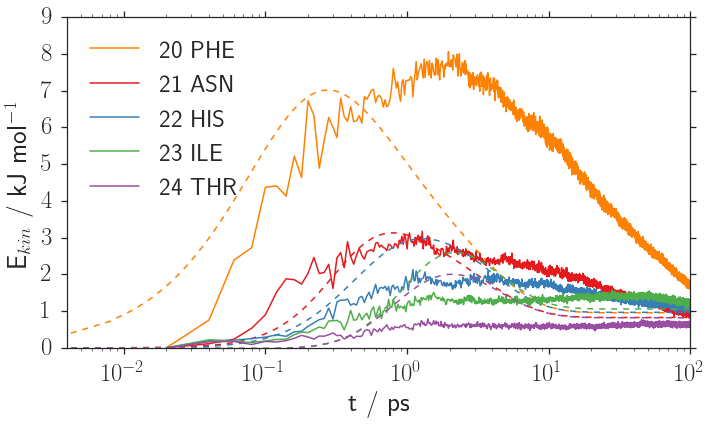

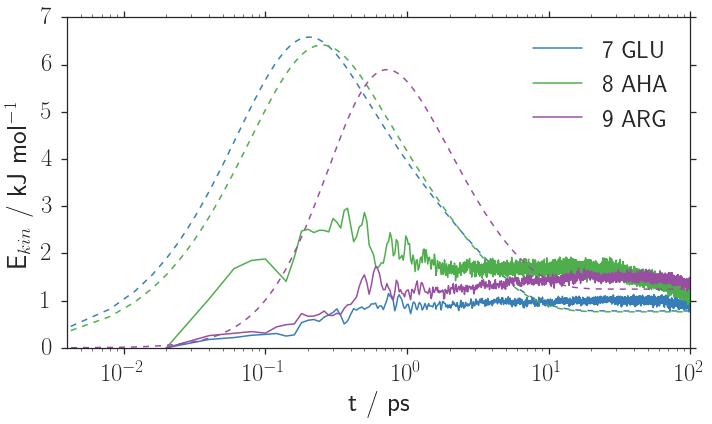

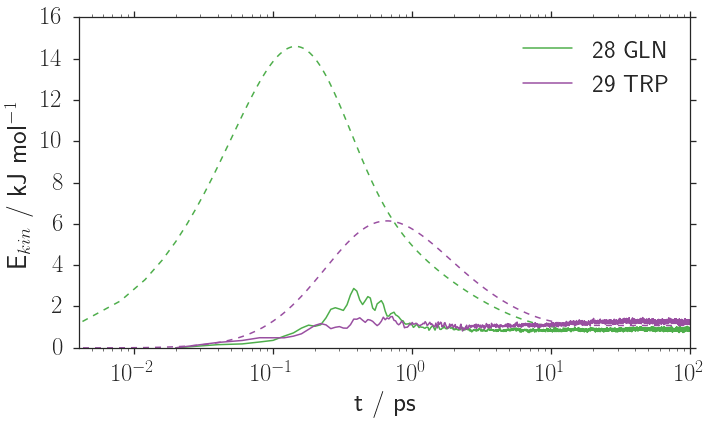

In [72]:
E_kin_MEQ = np.load('../working_files/E_kin_all_residues_MEQ.npy')/100
time_MEQ = np.linspace(0, 25000*4e-15, 25000)*1e12

print(E_kin_MEQ[-1,0])

plot_E_kin(E_kin_MD[16:18], time_MD, plotlabels[16:18], saveroot='E_kin_MEQ_MD', E_kin_model=E_kin_MEQ[16:18], t_model=time_MEQ)
plot_E_kin(E_kin_MD[18:19], time_MD, plotlabels[18:19], saveroot='E_kin_MEQ_MD', E_kin_model=E_kin_MEQ[18:19], t_model=time_MEQ, norm_to_zero=False)
plot_E_kin(E_kin_MD[19:24], time_MD, plotlabels[19:24], saveroot='E_kin_MEQ_MD', E_kin_model=E_kin_MEQ[19:24], t_model=time_MEQ)
plot_E_kin(E_kin_MD[6:9], time_MD, plotlabels[6:9], saveroot='E_kin_MEQ_MD', E_kin_model=E_kin_MEQ[6:9], t_model=time_MEQ)
plot_E_kin(E_kin_MD[27:29], time_MD, plotlabels[27:29], saveroot='E_kin_MEQ_MD', E_kin_model=E_kin_MEQ[27:29], t_model=time_MEQ)


# MEQ with excited limbo state
Trying to model the behaviour of the excited modes of AZU which will first have to decay vibronically to lower states for vibrational energy transport to happen. The initial distribution of the total kinetic energy of the heater between the limbostate * and the AZU residuum will be parametrized by the factor $\alpha$.
\begin{align*}
E_*^{init} &= \alpha \cdot E_{heat}^{init} \\ 
E_{AZU}^{init} &= (1-\alpha)\cdot E_{heat}^{init}
\end{align*}

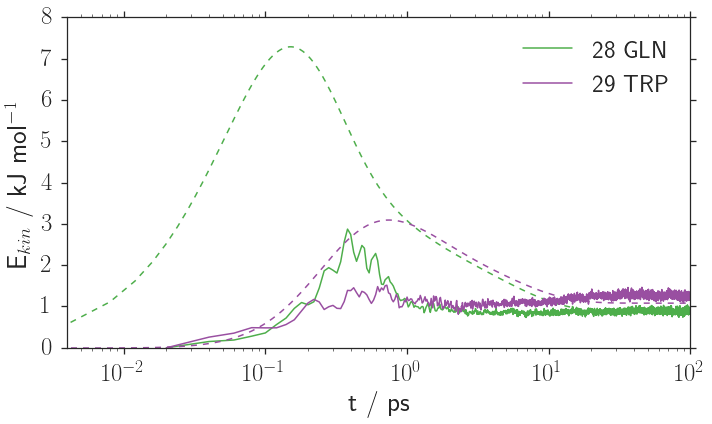

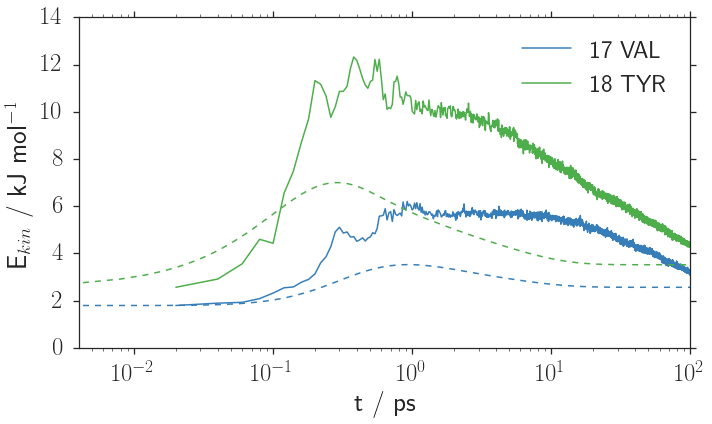

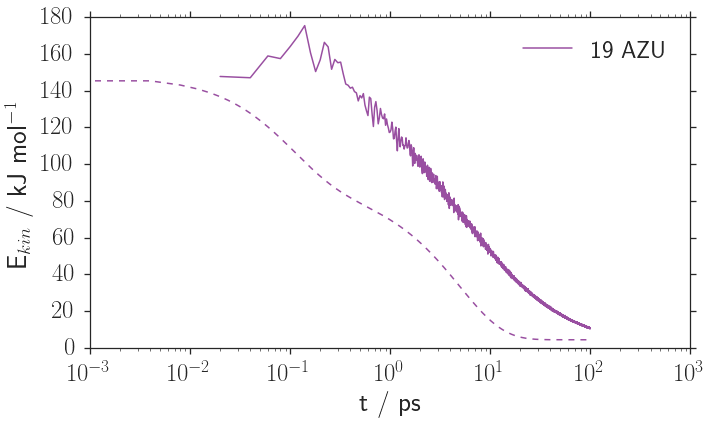

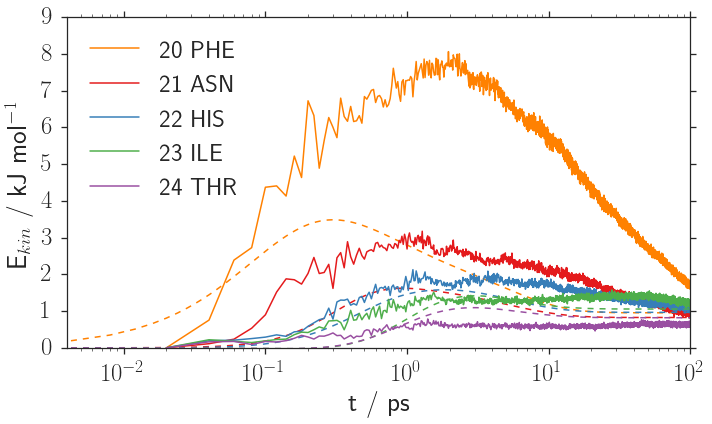

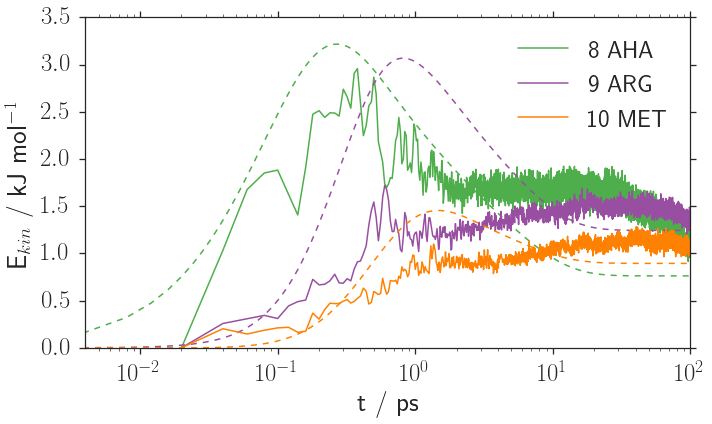

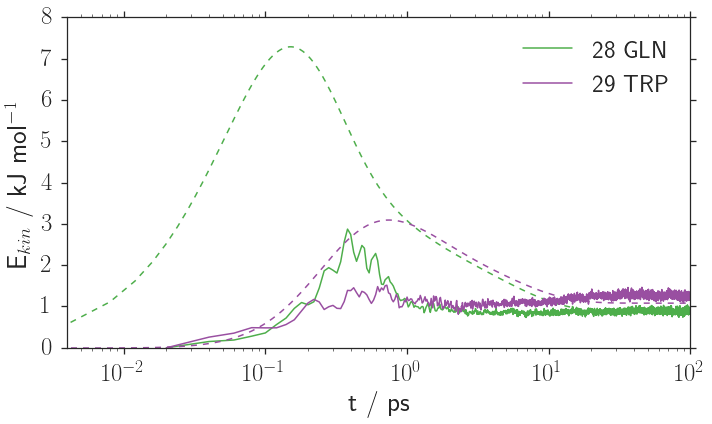

In [76]:
# import data from earlier MEQ runs
E_kin_init = E_kin_MEQ[:,0]
transition_rate_matrix = np.load("../working_files/910K/transition_rates_matrix.npy")

limbo_rate = 1/5e-12

# create energy vector for a system that is expanded by the limbo state
alpha = 0.5
E_kin_init_limbo = np.array(E_kin_init.tolist()+[0])
E_kin_init_limbo[-1] = alpha * E_kin_init[18]
E_kin_init_limbo[18] = (1-alpha) * E_kin_init[18]
E_kin_AZU = 67/2 * k_B * 10 /1000 *mol # thermal energy of azu assuming 67dof and 10K in kJ/mol

#print(E_kin_init_limbo)

# create transition rate matrix for expanded system
transition_rate_matrix_limbo = np.zeros((len(transition_rate_matrix)+1, len(transition_rate_matrix)+1))

for i,j in itertools.combinations_with_replacement(range(len(transition_rate_matrix)), 2):
    transition_rate_matrix_limbo[i,j] = transition_rate_matrix[i,j]
    transition_rate_matrix_limbo[j,i] = transition_rate_matrix[j,i]
    
limbo_index = len(transition_rate_matrix_limbo)-1
transition_rate_matrix_limbo[18, limbo_index] = limbo_rate
transition_rate_matrix_limbo[limbo_index, limbo_index] = -limbo_rate

transition_rate_matrix_limbo = np.matrix(transition_rate_matrix_limbo)

# run MEQ simulation
n_steps = 25000
dt = 4e-15

trm_dt = transition_rate_matrix_limbo * dt # scaled transition rate matrix

E_kin_evolution_limbo = np.matrix(np.zeros((len(E_kin_init_limbo), n_steps)))
E_kin_evolution_limbo[:,0] = np.matrix(E_kin_init_limbo).T

for i in range(n_steps-1):
    E_kin_evolution_limbo[:,i+1] = E_kin_evolution_limbo[:,i] + (trm_dt * E_kin_evolution_limbo[:,i])

E_kin_evolution_limbo = np.array(E_kin_evolution_limbo)

E_kin_AZU_limbo = E_kin_evolution_limbo[18] + E_kin_evolution_limbo[-1]

plot_E_kin(E_kin_MD[16:18], time_MD, plotlabels[16:18], saveroot='E_kin_MEQ_MD_split', E_kin_model=E_kin_evolution_limbo[16:18], t_model=time_MEQ, norm_to_zero=False)
plot_E_kin(E_kin_MD[18:19], time_MD, plotlabels[18:19], saveroot='E_kin_MEQ_MD_split', E_kin_model=[E_kin_AZU_limbo], t_model=time_MEQ, norm_to_zero=False)
plot_E_kin(E_kin_MD[19:24], time_MD, plotlabels[19:24], saveroot='E_kin_MEQ_MD_split', E_kin_model=E_kin_evolution_limbo[19:24], t_model=time_MEQ)
plot_E_kin(E_kin_MD[7:10], time_MD, plotlabels[7:10], saveroot='E_kin_MEQ_MD_split', E_kin_model=E_kin_evolution_limbo[7:10], t_model=time_MEQ)
plot_E_kin(E_kin_MD[27:29], time_MD, plotlabels[27:29], saveroot='E_kin_MEQ_MD_split', E_kin_model=E_kin_evolution_limbo[27:29], t_model=time_MEQ)


# Preparation of data for backtracking fit

In [20]:
class AnalyticError(Exception):
    pass

# energies of md run
try:
    with open('../working_files/BacktrackingData/MD_kinetic_energies.txt', 'w+') as f:
        #f.write('time / ps \t')

        if len(residue_names) != len(E_kin_MD):
            raise AnalyticError('Not all trajectories are evaluated yet!')

        #for resname in residue_names:
            #f.write('E({0}) / kJ/mol \t'.format(resname.replace(' ', '')))
        #f.write('\n')

        for i in range(len(time_MD)):
            f.write('{0} \t'.format(time_MD[i]))

            for n in range(len(E_kin_MD)):
                f.write('{0} \t'.format(E_kin_MD[n, i]))

            f.write('\n')
            
except Exception as e:
    print(e)
        
# mean distances along backbone
distances = np.loadtxt('../working_files/distance.txt', usecols=(2,))

with open('../working_files/BacktrackingData/backbone_mean_dist.txt', 'w+') as f:
    #f.write('Mean distances along backbone / nm \n')
    for i, d in enumerate(distances):
        f.write('{1} \t {2} \t {0} \n'.format(d, i+1, i+2))
        
# tertiary contacts and corresponding variances
tert_con = np.loadtxt('../working_files/tert_cont_var.txt')

with open ('../working_files/BacktrackingData/tertiary_cont_variances.txt', 'w+') as f:
    #f.write('i \t j \t sigma_ij \ nm^2 \n')
    
    for t in tert_con:
        f.write('{0:d} \t {1:d} \t {2} \n'.format(int(t[0]+1), int(t[1]+1), t[2]))
        
# residue pairs
with open('../working_files/BacktrackingData/residuepairs.txt', 'w+') as f:
    for i in range(len(residue_names)-1):
        f.write('{0:d} \t {1:d} \n'.format(i+1, i+2))
        
# rate estimates
with open('../working_files/BacktrackingData/first_estimates.txt', 'w+') as f:
    for r in [0, 0.5, 0, 0, 1/5.6, 1/240, 1.25, 1.1e-4, 2]:
        f.write('{0:f} \t'.format(r))

# Backtracking results

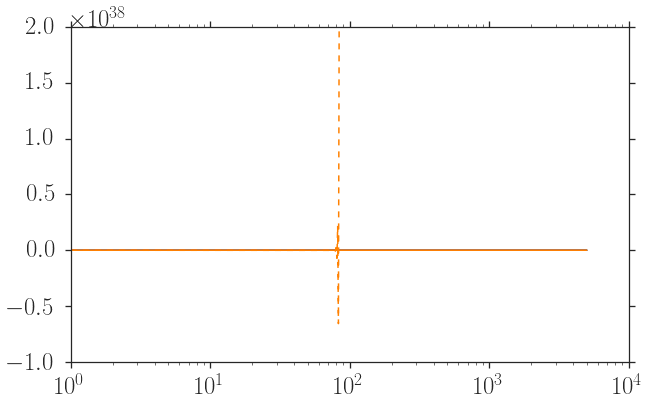

In [115]:
backtr_traj = np.loadtxt('../working_files/BacktrackingData/first_try_traj.txt')
backtr_fitted_traj = np.loadtxt('../working_files/BacktrackingData/fitted_trajectory.txt')
ref_traj = np.loadtxt('../working_files/BacktrackingData/MD_kinetic_energies.txt')
time = backtr_traj[:,0]

fig1 = plt.figure(figsize=(10,6))
axe1 = fig1.add_subplot(111)    


for i in range(14,19):
    line, = axe1.plot(ref_traj[:,i+1])
    if i == 18:
        axe1.plot(backtr_traj[:,i]+backtr_traj[:,i+1], color=line.get_color(), linestyle='--')
    if i != 18 and i != 19:
        axe1.plot(backtr_traj[:,i], color=line.get_color(), linestyle='--')

axe1.set_xscale('log')


# Transition matrices

In [ ]:
polar_rates_matrix = np.load('../working_files/polar_rates_matrix.npy')
print(polar_rates_matrix.shape)
axis = np.arange(1,37, 5)

def plot_rates_matrix(rates_mat):
    fig = plt.figure(figsize=(10,10))
    axe = fig.add_subplot(111)
    cmappable = axe.matshow(rates_mat*1e-12, cmap='viridis')

    axe.set_xticklabels(['']+axis.tolist())
    axe.set_yticklabels(['']+axis.tolist())
    
    divider = make_axes_locatable(axe)
    cax = divider.append_axes("right", size="5%", pad=0.5)

    cbar = plt.colorbar(cmappable, cax=cax, label='k / ps$^{-1}$')
    
    axe.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='on',         # ticks along the top edge are off
        labelbottom='off') # labels along the bottom edge are off
    
    axe.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        right='off',      # ticks along the bottom edge are off
        left='on',         # ticks along the top edge are off
        labelbottom='off') # labels along the bottom edge are off
    
    axe.minorticks_on()
    
    return fig

In [ ]:
bonded_rates_matrix = np.load('../working_files/bonded_rates_matrix.npy')
axis = np.arange(1,35)

polar_rates_matrix = np.load('../working_files/polar_rates_matrix.npy')
axis = np.arange(1,36, 5)


    
fig = plot_rates_matrix(polar_rates_matrix)
fig.savefig('../Plots/polar_rates_matrix.pdf')

fig = plot_rates_matrix(bonded_rates_matrix)
fig.savefig('../Plots/bonded_rates_matrix.pdf')

fig = plot_rates_matrix(polar_rates_matrix+bonded_rates_matrix)
fig.savefig('../Plots/total_rates_matrix.pdf')


bonded_rates_matrix[27, 28]

# Represenation of transition rates

In [ ]:
G=nx.DiGraph()
G.add_nodes_from([i for i in range(1,35)])

T = 2*np.pi*4/2/34

pos = {}
for i in range(1, 35):
    pos[i] = [i, -np.sin(T*i)] 

for i, j in itertools.combinations(range(34),2):
    if transition_rate_matrix[i,j] != 0:
        G.add_edge(i+1,j+1, weight = transition_rate_matrix[i,j])
        G.add_edge(j+1,i+1, weight = transition_rate_matrix[j,i])

print(pos)

nx.draw(G, pos, width=1.0)

# Latex tables

In [ ]:
with open('../working_files/BacktrackingData/degrees_of_freedom.txt', 'r') as dof_file:
    lines = dof_file.readlines()
    print(lines)
    if len(lines) == len(residue_names):
        with open('../Presentation/residues_dof.tex', 'w') as outfile:
            outfile.write('Residue & dof')
            for i, dof in enumerate(lines):
                outfile.write('\\\\ \n{0} & {1} '.format(residue_names[i].replace(' ', ''), dof.replace('\n', ''))) 
    

In [97]:
print(len(E_kin_MD[0]), len(E_kin_MEQ[0]))

5001 25000
